In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp
import numpy as np

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

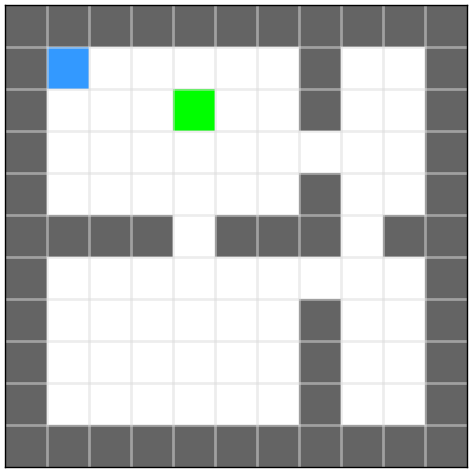

In [2]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts'))
test.reset()
test.render(return_img=False) 

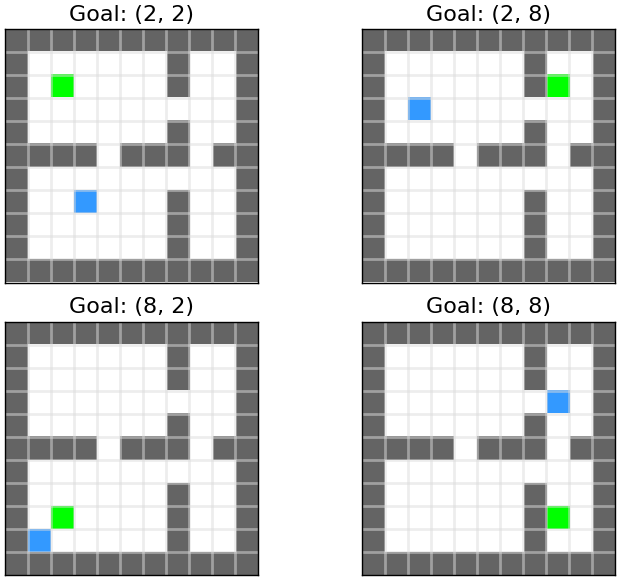

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

In [4]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze())
test.reset()
img = test.render(return_img=True) 

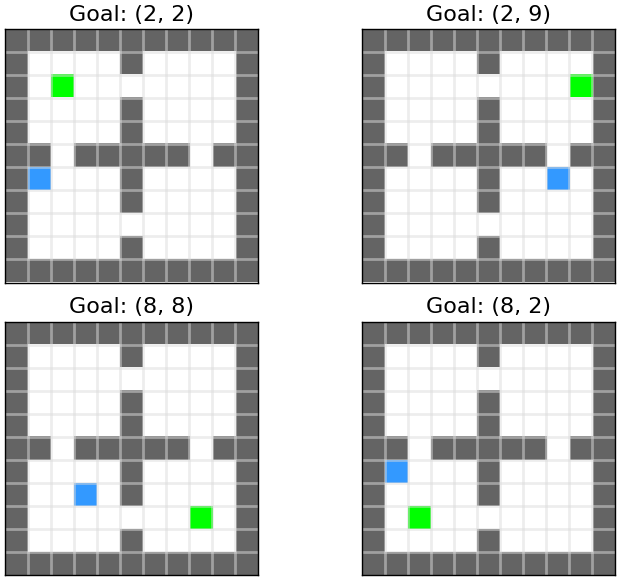

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

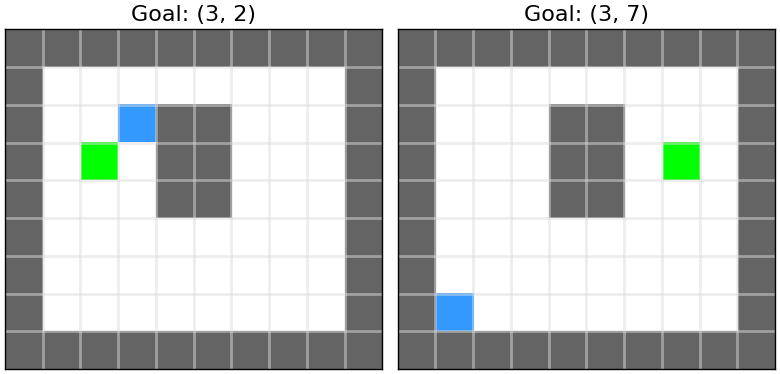

In [6]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(maze_type="gridworld"))
test.reset()

fig, ax = plt.subplots(nrows=1, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

# Data Collection for Maze

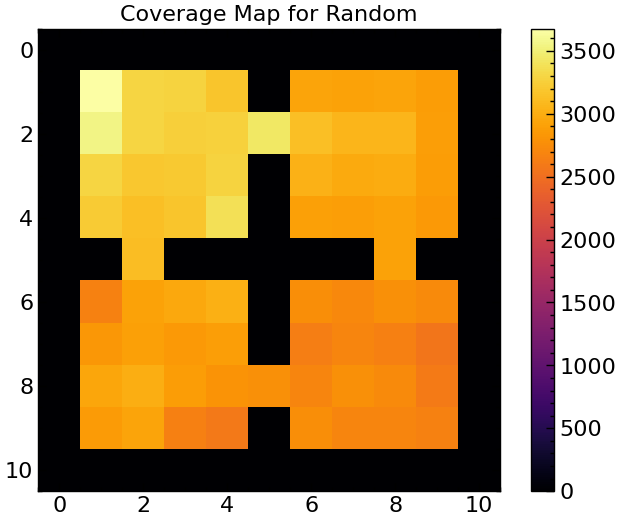

In [7]:
def random_exploration(env, num_episodes=1000, num_steps=200):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []

    for _ in range(num_episodes):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        while i < num_steps:
            i+=1
            cur_observations.append(np.array(state, dtype=np.float32))
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    return coverage_map, dataset

def uniform_exploration(env):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    dataset = dict()
    observations = []
    actions = []
    dones = []
    state_list = env.get_state_list()
    
    for i in range(state_list):
        for j in range(4):
            state, info = env.reset(options={'start': np.array(state_list[i])})
            observations.append(np.array(state, dtype=np.float32))
            actions.append(np.array(j, dtype=np.float32))
            next_state, reward, done, _, _ = env.step(j)
            dones.append(np.array(done, dtype=np.float32))
            coverage_map[next_state[0], next_state[1]] += 1
            
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    return coverage_map, dataset

def q_learning(env, num_episodes=500, horizon_T=200, alpha=0.1, gamma=0.99, epsilon=0.5):
    Q = np.zeros((env.maze.size[0], env.maze.size[1], env.action_space.n))
    coverage_map = np.where(env.maze_state == 1, -1000, env.maze_state)
    dataset = dict()
    observations = []
    actions = []
    dones = []
    
    for _ in tqdm(range(num_episodes), colour='green', leave=False):
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        done = False
        step = 0
        cur_observations = []
        cur_actions = []
        cur_dones = []
        
        #for j in range(horizon_T):
        while not done:
            cur_observations.append(np.array(state, dtype=np.float32))
            if (np.random.rand() < epsilon) or step < 100:# and j < 50:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state[0], state[1], :])
            
            next_state, reward, done, _, _ = env.step(action)
            cur_actions.append(np.array(action, dtype=np.float32))
            cur_dones.append(np.array(done, dtype=np.float32))
            
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
            
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            step+=1
            
        observations.append(np.stack(cur_observations))
        actions.append(np.stack(cur_actions))
        dones.append(np.stack(cur_dones))
        
    dataset['observations'] = np.concatenate(observations)
    dataset['terminals'] = np.concatenate(dones)
    dataset['actions'] = np.concatenate(actions)
    
    ob_mask = (1.0 - dataset['terminals']).astype(bool)
    next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
    dataset['next_observations'] = dataset['observations'][next_ob_mask]
    dataset['observations'] = dataset['observations'][ob_mask]
    dataset['actions'] = dataset['actions'][ob_mask][:, None]
    new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
    dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)
    
    return coverage_map, dataset

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

# Example usage
# env = FourRoomsMazeEnv(Maze(maze_type='gridworld'))
env = FourRoomsMazeEnv(Maze())
# coverage_unif, dataset_unif = random_exploration(env)
# visualize_coverage_map(coverage_unif, name='Uniform')

coverage_map_random, dataset_random = random_exploration(env)
visualize_coverage_map(coverage_map_random, name='Random')

# coverage_map_q_learning, dataset_q_learning = q_learning(env)
# visualize_coverage_map(coverage_map_q_learning, name='Qlearning')

In [8]:
from utils.datasets import Dataset

# whole_data = jax.tree.map(
#     lambda x, y: jnp.concatenate([x, y]), dataset_random, dataset_unif#, dataset_q_learning
# )
# whole_data = dataset_unif
whole_data = dataset_random
# whole_data['observations'] = jax.tree.map(lambda x: x / env.maze.size, whole_data['observations'])
# whole_data['next_observations'] = jax.tree.map(lambda x: x / env.maze.size, whole_data['next_observations'])
np.save("../aux_data/gridworld_data", arr=jax.device_get(whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))

In [9]:
from utils.datasets import GCDataset
import sys
sys.path.append("..")

from agents.fb import ForwardBackwardAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=discrete.yaml'])
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)
    
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
# fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

{
│   'seed': 1337,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 10000,
│   'eval_interval': 200000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [512, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True
│   },
│   'env': {'env_name': 'gridworld', 'discrete': True},
│   'tags': ['fb', 'discrete']
}

In [10]:
# with jax.disable_jit():
for _ in tqdm(range(10_000)):
    fb_agent, info = fb_agent.update(gc_whole_dataset.sample(1024))
info

  0%|          | 0/10000 [00:00<?, ?it/s]

{'fb/correct_b_ort': Array(68, dtype=int32),
 'fb/fb_diag_loss': Array(-526.2042, dtype=float32),
 'fb/fb_loss': Array(-418.69168, dtype=float32),
 'fb/fb_offdiag_loss': Array(71.55971, dtype=float32),
 'fb/mean_diag': Array(149.8952, dtype=float32),
 'fb/mean_off_diag': Array(2.3541088, dtype=float32),
 'fb/z_norm': Array(12.24745, dtype=float32),
 'grad/max': Array(211.94739, dtype=float32),
 'grad/mean': Array(0.02420471, dtype=float32),
 'grad/min': Array(-328.48398, dtype=float32),
 'grad/norm': Array(3504.7764, dtype=float32)}

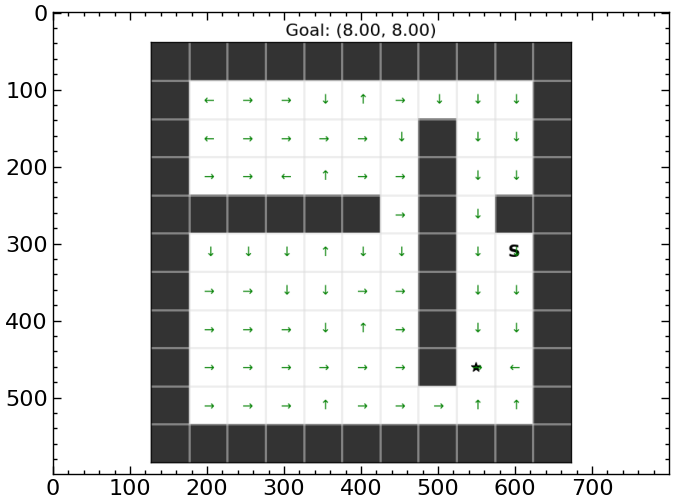

In [28]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
env.reset() # for testing FB on new layout

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = fb_agent.infer_z(goal)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_fourrooms(env, example_batch, N=11, M=11,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

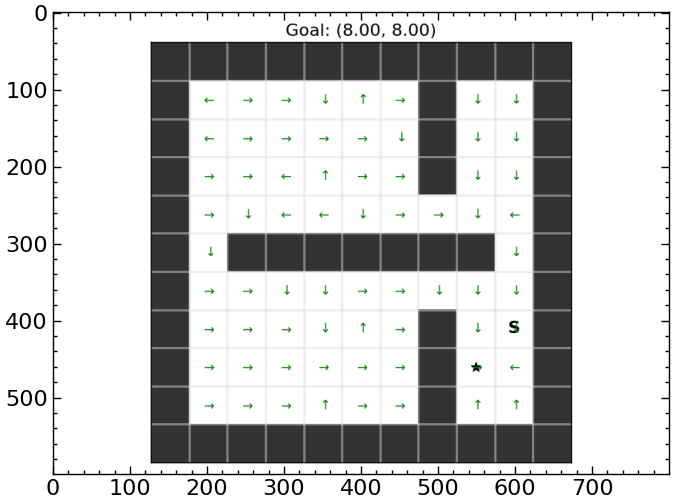

In [29]:
from envs.custom_mazes.env_utils import policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng

env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
env.reset() # for testing FB on new layout

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = fb_agent.infer_z(goal)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_fourrooms(env, example_batch, N=11, M=11,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

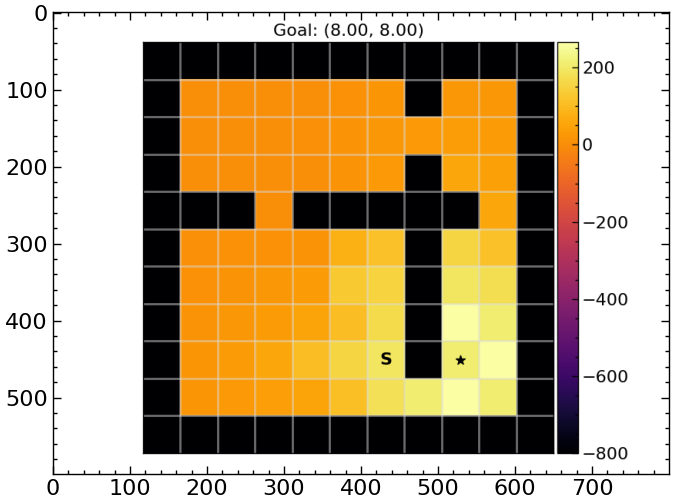

In [27]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = env.maze.size
pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
plt.imshow(pred_value_img)

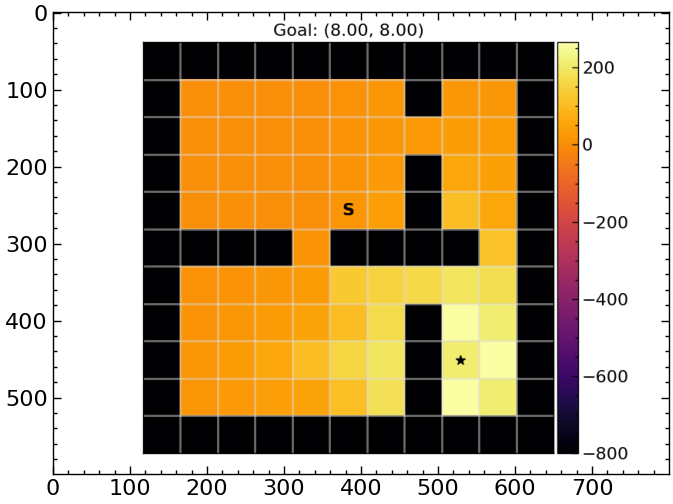

In [24]:
from envs.custom_mazes.env_utils import value_image_fourrooms
from functools import partial

env = FourRoomsMazeEnv(Maze(maze_type='fourrooms_random_layouts', size=11))
env.reset() # for testing FB on new layout

observation, info = env.setup_goals(seed=None, task_num=0)
goal = info.get("goal_pos", None)
latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
N, M = env.maze.size
pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                            value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
plt.imshow(pred_value_img)